**Ch34-39: 集成学习、AdaBoost与RandomForest、参数调优**

Source: 
[数据分析实战 45 讲](https://time.geekbang.org/column/intro/100021701?tab=intro)

---

> 哈哈哈哈哈哈哈哈哈哈哈哈哈“决策树桩子”这个称呼真的看一次笑一次，承包了今天所有的笑点哈哈哈哈哈哈哈
>> 不行'Random Forest'知道了它的原理以后跟桩子一样好好玩哈哈哈哈哈

# 集成学习 (Ensemble learning)

* 是一个框架，通过构造和使用多个弱分类器（用什么分类器就可以指定是决策树这些具体的）集成完成分类任务。每个分类器的准确率要比随机分类的好，即准确率大于50%；每个弱分类器应该尽量相互独立，这样才能博采众长，否则多个分类器一起工作，和单个分类器工作相差不大。

* 通常会基于单个分类器之间是否存在依赖关系，进而分成Boosting或者Bagging方法：

    * 如果每个分类器存在较强的依赖关系，**需要串行**使用，当引入第K个分类器时，实际上是对前K-1个分类器的优化（这样子串行着迭代着优化），即相当于让这K个分类器全进行加权了的**融合**，就是Boosting方法。

    * 如果每个分类器可以**并行**工作，最后再选择出现最多的那个类作为最终分类结果，就是Bagging（**B**ootstrapped + **agg**regated) 或者Random forest（Bagging的升级版）。

## AdaBoost (Adaptive Boosting)

通过改变样本的数据分布/**权重集合**来实现的。AdaBoost会判断每次训练的样本是否正确分类，**对于正确分类的样本，降低它的权重，对于被错误分类的样本，增加它的权重**。再基于上一次得到的分类准确率，来确定这次训练样本中每个样本的权重(可以让训练的焦点集中到难分类的样本上)。然后将**修改过权重的新数据集传递给下一层的分类器**(即，在当前第K轮数据集输入下的*准确率最高*/分类错误率最低的那个弱分类器)进行训练。
   
* 在每一轮的训练中都会加入一个"新"的弱分类器，直到达到足够低的错误率或者达到指定的最大迭代次数为止（这个分类器是每一次**迭代**中计算出来的，所以才说是新的分类器，不是事先准备好的）。

* 上文不是说“用什么分类器就可以指定是决策树这些具体的”嘛，这个决策树**弱**分类器跟我们一般的决策树不同的，它相当于是: `DecisionTreeClassifier(min_samples_leaf=1,max_depth=1)` ，第一个参数允许叶子节点仅包含一个样本，意思就是完全不限制分叉后的样本数，`max_depth=1`意味着此弱分类器树只有根节点加一层叶子节点，称为“决策树桩”，就是最简单的决策树形式啦～～
    * 显然，逻辑上就是一个带有if-else规则的最简分类器：
      ```python
        if feature_X > threshold:
            return class_A
        else:
            return class_B
      ```
### 构造参数

```python
AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)

AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss=‘linear’, random_state=None)
```

- `base_estimator`: 选的是弱分类器，默认的就是这种决策树桩子（哈哈哈好搞笑的名字）

- `n_estimators`: 最大迭代次数，也就是那”K个弱分类器“K的取值；`learning_rate`: 从0-1，与`n_estimators`相关，不然这俩都小模型难收敛哇。

- `random_state`: 随机种子的设置（记得不，这个指定了一个数，其取值不变时划分得到的随机模式及最后跑出来的结果一摸一样，可以复现。在`train_test_split`中也有这个参数）。

- （仅分类中有）`algorithm`: 对上述所讲的那个权重的计算方法。

- （仅回归中有）`loss`: loss function嘛，determines how the weights of the training samples are updated after each boosting iteration. 'linear' (default; the weight update is proportional to the absolute error) -> 'square' (proportional to the squared error) -> 'exponential'; increasing sensitivity to large errors. 

### 顺便用到了sklearn.multioutput的MultiOutputRegressor

> A simple strategy for extending regressors that **do not natively support multi-target regression** (eg. AdaBoost).

`MultiOutputRegressor(estimator, *, n_jobs=None)` 

- `estimator`: 就是你的模型对象，which *actually* implements `fit()` and `predict()`.

---

## Random Forest
'Forest'由很多个decision 'tree'构成，好家伙，这名字跟决策树'stump'一样令人快乐wwwwww。

* 用**bootstrap**得到的数据集建`n_estimators`棵最大层深为`max_depth`（这里跟Boosting算法不同，不会把弱分类器只限制为桩子!!）的树，**所有树并行分类，取最多的那个类别为最终结果**。

* RF做回归时是**取每棵回归树的结果的加权平均**，一样是并行，不像Adaboost回归是在迭代K次中优化loss function。

注：[StatQuest: Random Forests Part 1 - Building, Using and Evaluating](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ), BAM!

## GridSearchCV寻找模型的最优参数

每一种模型都有这么多乱七八糟的构造参数（还有好多好多我没记笔记）。`sklearn.model_selection`提供这样一个工具，给定参数范围（传入dict，`{"参数名":[参数取值范围]}`），找到最优参数~~~

`GridSearchCV(estimator, param_grid, cv=None, scoring=None)` `estimator`为分类器对象，`param_grid`就是刚那个dict，然后`.fit(x,y)`的就是这个GridSearchCV对象了，它会给出最优参数下的score。

## Pipeline管道机制 简化代码

详见最后一个代码块！！那里面还有分类器比较

`sklearn.pipeline`的Pipeline类，实例化时是以`('名称',某个对象)`这样子的**双元组** 再按步骤顺序组成的列表 作为构造参数，比如：
```python
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('randomforestclassifier', RandomForestClassifier())])
```

In [3]:
from sklearn.datasets import load_linnerud  # a multi-output regression task
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# inspect the data
dataset = load_linnerud(as_frame=True)  # 这个默认为False，生成ndarray
print(dataset.feature_names)
features = dataset.data
targets = dataset.target
print(features.head())
print(targets.head())
print(features.describe())
print(features.info())
# 这里面特征啥的都好少，直接老步骤开训练。决策树不是基于距离所以应该也不用规范化
tr_f1,te_f1,tr_t1,te_t1 = train_test_split(features,targets,test_size=0.2,random_state=42)
# adaboost = AdaBoostRegressor()
# adaboost.fit(tr_f1,tr_t1)  这里要报错，因为Adaboost并不接受multi-output regression, tr_t1必须是1d array不能有三列
# (RandomForest就支持)
# 使用 MultiOutputRegressor 作为**wrapper**, trains one separate AdaBoost model per target (共三个target)
from sklearn.multioutput import MultiOutputRegressor
# Wrap AdaBoostRegressor

multi_ada = MultiOutputRegressor(AdaBoostRegressor(random_state=42))  # WRAP 起来！！！！

multi_ada.fit(tr_f1, tr_t1)  # Now tr_t1 can be 2D (samples × 3 targets)
te_p1 = multi_ada.predict(te_f1)
print(te_p1,"\n可怕，跟target相差真够大的,这个数据集样本量太小了一共才20个训练集分成来就更小力\n",te_t1)
print(f'AdaBoost回归偏差为:{mean_squared_error(te_t1,te_p1):.4f}，一般来说AdaBoost比KNN还是决策树做回归偏差都更小的')
print('别忘了KNN咋做回归，复制那一节的笔记：:"对于一个新的数据点，找出K个最近的邻居，将他们各自的属性取值加权平均赋给该点"')



['Chins', 'Situps', 'Jumps']
   Chins  Situps  Jumps
0    5.0   162.0   60.0
1    2.0   110.0   60.0
2   12.0   101.0  101.0
3   12.0   105.0   37.0
4   13.0   155.0   58.0
   Weight  Waist  Pulse
0   191.0   36.0   50.0
1   189.0   37.0   52.0
2   193.0   38.0   58.0
3   162.0   35.0   62.0
4   189.0   35.0   46.0
           Chins      Situps      Jumps
count  20.000000   20.000000   20.00000
mean    9.450000  145.550000   70.30000
std     5.286278   62.566575   51.27747
min     1.000000   50.000000   25.00000
25%     4.750000  101.000000   39.50000
50%    11.500000  122.500000   54.00000
75%    13.250000  210.000000   85.25000
max    17.000000  251.000000  250.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chins   20 non-null     float64
 1   Situps  20 non-null     float64
 2   Jumps   20 non-null     float64
dtypes: float64(3)
memory usage: 612

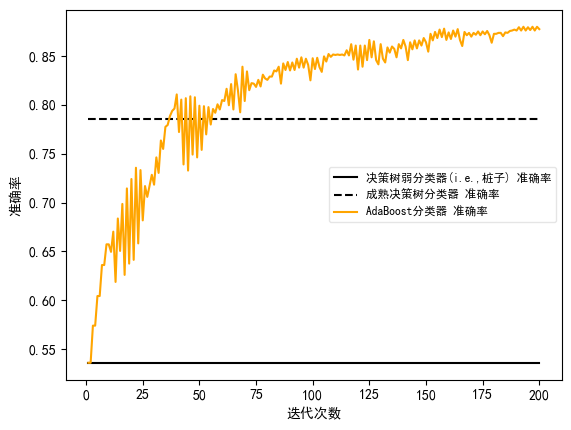

In [5]:
# AdaBoost与决策树桩子（不行这个名字我真的看一次笑一次）与不是桩子的正常的决策树在分类任务上的比较

# 主要你要学习这个“比较”该怎么可视化！！！！！！！！还要可视化随着adaboost迭代次数增长的收敛情况
# 这里使用随机生成数据，用sklearn.datasets的make_hastie_10_2()生成二分类数据

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier 
import numpy as np
from sklearn.metrics import zero_one_loss

feature,target = datasets.make_hastie_10_2(n_samples=13000,random_state=1)  #随机种子给它固定住了
tr_f2,te_f2,tr_t2,te_t2 = train_test_split(feature,target,test_size=0.16)  
stump = DecisionTreeClassifier(min_samples_leaf=1,max_depth=1) # 这就是那个笨笨的桩子stump哈哈哈哈哈哈
stump.fit(tr_f2,tr_t2)
stump_score = stump.score(te_f2,te_t2)   #（不用predict了直接用模型对象的score()方法喵）
mature_tree = DecisionTreeClassifier() # 一般路过平平无奇的成熟后决策树一棵; 变量名写太长了，只是想好玩，呜呜
mature_tree.fit(tr_f2,tr_t2)
mature_tree_score = mature_tree.score(te_f2,te_t2)
num_estimators = 200   # 在外面而不是直接在参数里设置AdaBoost迭代次数，为了一会可视化的时候看随着迭代次数增长收敛情况
ada = AdaBoostClassifier(stump,n_estimators=num_estimators)
ada.fit(tr_f2,tr_t2)

fig = plt.figure()
plt.rcParams['font.sans-serif'] = ['SimHei'] # correctly display Chinese

ax = fig.add_subplot(111) # you remember this parameter don't you; 这是要加一条线图上的线！！！
ax.plot([1,num_estimators],[stump_score,stump_score],'k-',label='决策树弱分类器(i.e.,桩子) 准确率')
# ax.plot(x, y) 要求x和y的数组长度必须一致，程序才能配对坐标。'k-'/'k--'分别表示黑色实线和虚线
ax.plot([1,num_estimators],[mature_tree_score,mature_tree_score],'k--',label='成熟决策树分类器 准确率')

ada_score = np.zeros((num_estimators,))
# 遍历每次迭代结果，i为迭代次数, staged_predict又是个神奇方法，大概专门为了这种可视化任务？
for i, a_pred in enumerate(ada.staged_predict(te_f2)):
    ada_score[i] = 1-zero_one_loss(a_pred,te_t2)   
# zero_one_loss是*二分类*问题中常见且非常严苛的分类损失函数，预测类别与真实标签一致是为0否则一律为1，返回预测错的占总样本数的比例即错误率，我们把它改成准确率。。。
ax.plot(np.arange(num_estimators)+1,ada_score,label='AdaBoost分类器 准确率',color='orange') #设为橙色，区分
# 注意那个np.arange(num_estimators)+1，不然x轴上就是从0开始到(n-1)而不是从第一次epoch到第n次，增强了可读性
# 在外部+1后给每个元素都加上1是ndarray的broadcast机制吧，Series也支持，超方便
ax.set_xlabel("迭代次数")
ax.set_ylabel("准确率")
leg = ax.legend(loc='center right',fancybox=True,fontsize='small',framealpha=0.5) 
# 添加图例（在右边,fancybox设置圆边框,字体小一点再让它半透明化，之前在右上的时候老挡住线）
plt.savefig('L35_AdaBoost迭代及三种分类器比较.png') # 好好用的函数，后缀写什么它就导出成什么。
# ！！！！！！注意show()一定要在它后面要不然到处出来啥也没有
plt.show()

In [27]:
# Applying GridSearchCV to optimize parameter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris

iris = load_iris()
rf = RandomForestClassifier()
clf = GridSearchCV(estimator=rf,param_grid={'n_estimators':range(2,15)}) # 注意每个都是KeywordArgument，得用参数名传参
clf.fit(iris.data,iris.target)
print(f'最优参数：{clf.best_params_}')
print(f'此时结果：{clf.best_score_:.4f}')       #其实我发现，每次都变，根本不固定。。。。。  

最优参数：{'n_estimators': 5}
此时结果：0.9667


In [48]:
# Applying pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler',StandardScaler()),('rf',RandomForestClassifier())])   
# 注意这种情况下下面参数得指定是哪个步骤的
clf_pipeline = GridSearchCV(estimator=pipeline,param_grid={'rf__n_estimators':range(2,15)})
clf_pipeline.fit(iris.data,iris.target)
print(f'最优参数：{clf_pipeline.best_params_}')
print(f'此时结果：{clf_pipeline.best_score_:.4f}')   # 一样，最优参数和结果每次都变

最优参数：{'rf__n_estimators': 10}
此时结果：0.9733


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

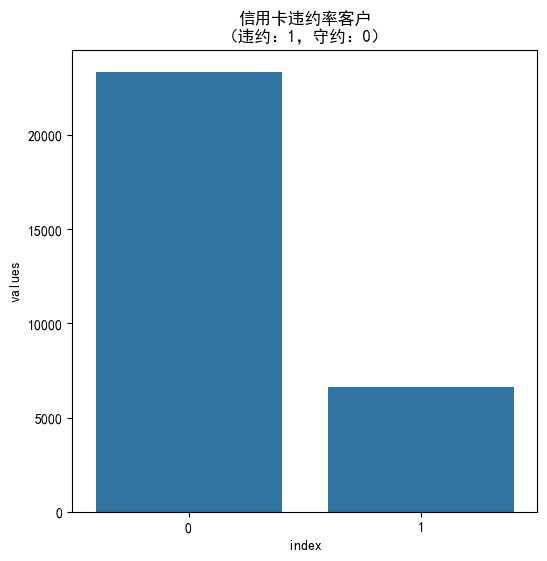

现在是tree
最优参数：{'tree__max_depth': 6}
此时结果：0.8196
模型准确率：0.8186666666666667
花费时间：3.4216344589985965s

现在是svm
最优参数：{'svm__C': 1.5, 'svm__gamma': 0.02}
此时结果：0.8197
模型准确率：0.8171111111111111
花费时间：167.5000508339981s

现在是knn
最优参数：{'knn__n_neighbors': 8}
此时结果：0.8043
模型准确率：0.806
花费时间：4.260183708000113s

现在是ada
最优参数：{'ada__n_estimators': 50}
此时结果：0.8204
模型准确率：0.8161111111111111
花费时间：25.750299250001262s

现在是rf2
最优参数：{'rf2__n_estimators': 14}
此时结果：0.8085
模型准确率：0.8062222222222222
花费时间：8.459539666997443s



In [87]:
# 实战   多比较几个模型,准备直接用模型对象的.score()方法
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# 这个数据集有点大有的跑起来好慢（一度害怕是我的电脑坏了我的天）
import time

dataset = pd.read_csv("L39上课数据.csv")
print(dataset.info(),"\n",dataset.head(3))
features = dataset.drop(["ID","default.payment.next.month"],axis=1)
targets = dataset["default.payment.next.month"]
temp = targets.value_counts()
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(6,6))
plt.title('信用卡违约率客户\n（违约：1，守约：0）')
sns.set_color_codes("pastel")
sns.barplot(x='index',y='values',data=pd.DataFrame({'index':temp.index,'values':temp.values})) 

plt.show()

# 注意，是先x后y不是先train后test。。。我今天写错了
train_x,test_x,train_y,test_y = train_test_split(features,targets,test_size=0.3,random_state=1)

models = [DecisionTreeClassifier(random_state=1),SVC(random_state=1),KNeighborsClassifier(),AdaBoostClassifier(random_state=1),RandomForestClassifier(random_state=1)]
model_names = ['tree','svm','knn','ada','rf2']
params = [{'tree__max_depth':[6,9,11]},
          {'svm__C':[1,1.5],'svm__gamma':[0.01,0.02]},
          {'knn__n_neighbors':[4,6,8]},
          {'ada__n_estimators':[10,50,100]},
          {'rf2__n_estimators':[6,9,14]}]
def pipe(pipeline,train_x,train_y,test_x,test_y,param):
    pipe = GridSearchCV(estimator=pipeline,param_grid=param)
    pipe.fit(train_x,train_y)
    print(f'最优参数：{pipe.best_params_}')
    print(f'此时结果：{pipe.best_score_:.4f}')
    print(f'模型准确率：{pipe.score(test_x,test_y)}')

for model_name,model,param in zip(model_names,models,params):
    pipeline2 = Pipeline([('ss',StandardScaler()),(model_name,model)])
    print(f'现在是{model_name}')
    start_time = time.perf_counter()    
    pipe(pipeline2,train_x,train_y,test_x,test_y,param)
    end_time = time.perf_counter()
    print(f'花费时间：{end_time-start_time}s\n')

